In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

После того, как загрузили базовые пакеты, считываем датасеты и сохраняем их в перемененные

In [28]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-anton-zhuravlev/shared/problem1-reg_data.csv', sep=';')

In [29]:
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-anton-zhuravlev/shared/problem1-auth_data.csv', sep=';')

In [30]:
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [31]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Проверив, что датасеты загружены корректно, проверяем их размер (количество строк и столбцов)

In [32]:
reg_data.shape

(1000000, 2)

In [33]:
auth_data.shape

(9601013, 2)

Проверяем формат столбцов наших датафреймов

In [34]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [35]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

Размеры датасетов существенно различаются, поэтому проверим соответствуют ли uid пользователей

In [36]:
auth_data['uid'].nunique()

1000000

In [37]:
reg_data['uid'].nunique() # все хорошо, количество uid равны

1000000

Проверяем датасеты на наличие пропущенных значений

In [38]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [39]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

Посчитаем количество дублирующихся значений

In [40]:
len(reg_data['uid'])- len(reg_data['uid'].drop_duplicates())

0

In [41]:
len(auth_data['uid'])- len(auth_data['uid'].drop_duplicates())

8601013

столбцы auth_ts и reg_ts не в формате даты, поэтому переведем их в нужный формат

In [42]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date

In [43]:
reg_data.dtypes

reg_ts    object
uid        int64
dtype: object

In [44]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date

In [45]:
auth_data.dtypes

auth_ts    object
uid         int64
dtype: object

Проверим максимальные и минимальные значения дат

In [46]:
auth_data['auth_ts'].max()

datetime.date(2020, 9, 23)

In [47]:
auth_data['auth_ts'].min()

datetime.date(1998, 11, 18)

In [48]:
reg_data['reg_ts'].max()

datetime.date(2020, 9, 23)

In [49]:
reg_data['reg_ts'].min()

datetime.date(1998, 11, 18)

## Задание 1. Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Retention rate (RR) — коэффициент удержания клиентов. 
Retention Rate = (Количество активных пользователей на текущий день / Количество активных пользователей на первый день) × 100 %

In [50]:
full_data = auth_data.merge(reg_data, how='inner', on='uid')
full_data

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


Собираю все в функцию

In [69]:
def RR(data, start_date, final_date):
    '''Функция принимает на вход датасет с датами регистрации и авторизации пользователей
       Приводит данные в формат pivot-таблицы, считает retention по дням от даты регистрации и
       строит тепловую карту.
       Важно!!! в зависимости от значений RR меняем значение vmax в строке кода,
       где мы строим график, чтобы цвет не блекнул.
       К тому же, необходимо диапазон также корректировать в зависимости от задаваемых значений
       start_date и final_date c помощью параметра fontsize'''
    start_date = pd.to_datetime(start_date) # переводим наши установочные данные в формат даты
    final_date = pd.to_datetime(final_date) # переводим наши установочные данные в формат даты
    data = data.loc[(data['reg_ts'] >= start_date) & (data['auth_ts'] <= final_date)].copy() # применяем установочные данные к датасету
    data['days'] = (data['auth_ts'] -  data['reg_ts']).dt.days # находим разницу в днях между дата авторизации и датой регистрации
    data_pivot = data.pivot_table(index='reg_ts', columns='days', values='uid', aggfunc='nunique') # делаем pivot таблицу
    zero_day = data_pivot.iloc[:,0] # задаем переменную нулевому дню (день когда пользователи регистрировались)
    retention = np.round(data_pivot.divide(zero_day, axis=0).multiply(100), 2) # считаем retention
    plt.show()
    plt.figure(figsize=(20, 15)) # строим график
    
    mask = np.full_like(retention, True, dtype=bool)
    mask[0:20, 1:20] = False # замаскировал значения 0-го дня
    
    plt.title('Retention rate игроков c {} по {}'.format(start_date, final_date), fontsize=20)
    sns.heatmap(retention, vmin=0.0, vmax=9, linewidths=1, annot=True, mask=mask)
    plt.ylabel('Дата регистрации', fontsize=20) 
    plt.xlabel('Количество дней посещения игры с момента регистрации', fontsize=15)
    plt.show()

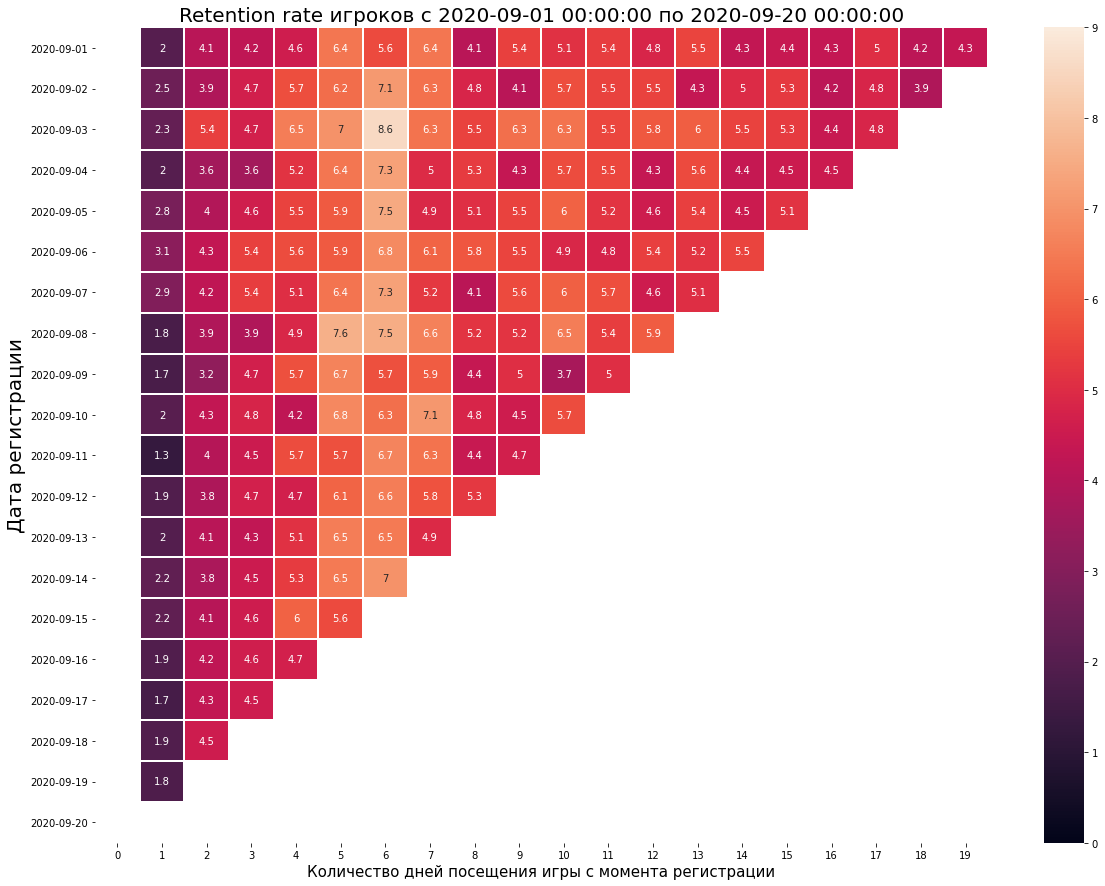

In [70]:
RR(full_data, '2020-09-01', '2020-09-20')